In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Make sure to import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [24]:
# Load Dataset
def load_dataset():
    df = pd.read_csv('/content/heart_disease_uci.csv')  # Update with your file path if needed
    return df

# Load and display the first few rows of the dataset
df = load_dataset()
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [25]:

# Preprocess Data: Encode Categorical Features
def preprocess_data(df):
    # Convert categorical columns to numeric (one-hot encoding or label encoding)
    df = pd.get_dummies(df, drop_first=True)
    return df

In [26]:
# Apply preprocessing
df = preprocess_data(df)
print("Data after encoding categorical features:\n", df.head())

Data after encoding categorical features:
    id  age  trestbps   chol  thalch  oldpeak   ca  num  sex_Male  \
0   1   63     145.0  233.0   150.0      2.3  0.0    0      True   
1   2   67     160.0  286.0   108.0      1.5  3.0    2      True   
2   3   67     120.0  229.0   129.0      2.6  2.0    1      True   
3   4   37     130.0  250.0   187.0      3.5  0.0    0      True   
4   5   41     130.0  204.0   172.0      1.4  0.0    0     False   

   dataset_Hungary  ...  cp_non-anginal  cp_typical angina  fbs_True  \
0            False  ...           False               True      True   
1            False  ...           False              False     False   
2            False  ...           False              False     False   
3            False  ...            True              False     False   
4            False  ...           False              False     False   

   restecg_normal  restecg_st-t abnormality  exang_True  slope_flat  \
0           False                     False 

In [27]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Handle missing values (fill with mean, median, or drop)
# Here, we're using SimpleImputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

Missing values in each column:
 id                            0
age                           0
trestbps                     59
chol                         30
thalch                       55
oldpeak                      62
ca                          611
num                           0
sex_Male                      0
dataset_Hungary               0
dataset_Switzerland           0
dataset_VA Long Beach         0
cp_atypical angina            0
cp_non-anginal                0
cp_typical angina             0
fbs_True                      0
restecg_normal                0
restecg_st-t abnormality      0
exang_True                    0
slope_flat                    0
slope_upsloping               0
thal_normal                   0
thal_reversable defect        0
dtype: int64


In [28]:
# Data Normalization (Z-score)
def normalize_data(df):
    scaler = StandardScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return normalized_df

In [30]:
# Normalize the data
normalized_df = normalize_data(df_imputed)
print("Normalized Data:\n", normalized_df.head())

Normalized Data:
          id       age  trestbps      chol    thalch   oldpeak        ca  \
0 -1.730169  1.007386  0.698041  0.311021  0.495698  1.349421 -1.249371   
1 -1.726404  1.432034  1.511761  0.797713 -1.175955  0.589832  4.292099   
2 -1.722639  1.432034 -0.658158  0.274289 -0.340128  1.634267  2.444942   
3 -1.718873 -1.752828 -0.115679  0.467130  1.968345  2.488805 -1.249371   
4 -1.715108 -1.328180 -0.115679  0.044717  1.371326  0.494884 -1.249371   

        num  sex_Male  dataset_Hungary  ...  cp_non-anginal  \
0 -0.871794  0.516931        -0.683597  ...       -0.533775   
1  0.879408  0.516931        -0.683597  ...       -0.533775   
2  0.003807  0.516931        -0.683597  ...       -0.533775   
3 -0.871794  0.516931        -0.683597  ...        1.873447   
4 -0.871794 -1.934494        -0.683597  ...       -0.533775   

   cp_typical angina  fbs_True  restecg_normal  restecg_st-t abnormality  \
0           4.358899  2.380476       -1.221976                 -0.491493   


In [31]:
# Anomaly Detection functions here
# Z-score Based Anomaly Detection
def z_score_anomaly_detection(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    anomalies = (z_scores > threshold).any(axis=1)
    return anomalies

In [32]:
# Mahalanobis Distance Based Anomaly Detection
def mahalanobis_anomaly_detection(df):
    mean = df.mean().values
    cov_matrix = np.cov(df.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    distances = df.apply(lambda row: mahalanobis(row, mean, inv_cov_matrix), axis=1)
    threshold = np.percentile(distances, 97.5)
    anomalies = distances > threshold
    return anomalies

In [33]:
# Local Outlier Factor (LOF) Anomaly Detection
def lof_anomaly_detection(df, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    labels = lof.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [34]:
# Isolation Forest Anomaly Detection
def isolation_forest_anomaly_detection(df):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    labels = iso_forest.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [35]:
# One-Class SVM Anomaly Detection
def one_class_svm_anomaly_detection(df):
    oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
    labels = oc_svm.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [36]:
# Apply Anomaly Detection Methods
z_anomalies = z_score_anomaly_detection(normalized_df)
print(f"Z-score detected {z_anomalies.sum()} anomalies.")


Z-score detected 81 anomalies.


In [37]:
m_anomalies = mahalanobis_anomaly_detection(normalized_df)
print(f"Mahalanobis Distance detected {m_anomalies.sum()} anomalies.")

Mahalanobis Distance detected 23 anomalies.


In [38]:
lof_anomalies = lof_anomaly_detection(normalized_df)
print(f"LOF detected {lof_anomalies.sum()} anomalies.")

LOF detected 16 anomalies.


In [39]:
iso_forest_anomalies = isolation_forest_anomaly_detection(normalized_df)
print(f"Isolation Forest detected {iso_forest_anomalies.sum()} anomalies.")

Isolation Forest detected 46 anomalies.


In [40]:

svm_anomalies = one_class_svm_anomaly_detection(normalized_df)
print(f"One-Class SVM detected {svm_anomalies.sum()} anomalies.")

One-Class SVM detected 163 anomalies.


Evaluation Metrics for Anomaly Detection Methods:
                  Precision    Recall  Accuracy
Z-score            0.024691  0.052632  0.875000
Mahalanobis        0.043478  0.026316  0.935870
LOF                0.062500  0.026316  0.943478
Isolation Forest   0.021739  0.026316  0.910870
One-Class SVM      0.049080  0.210526  0.798913


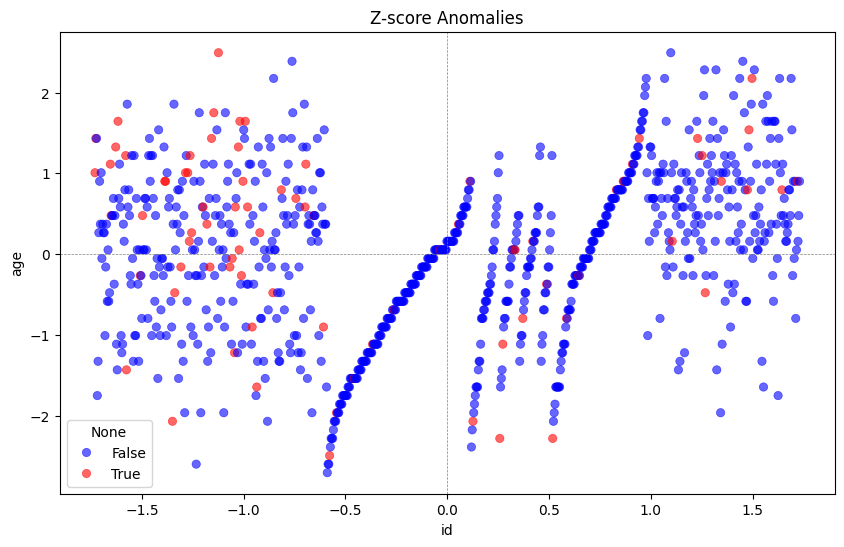

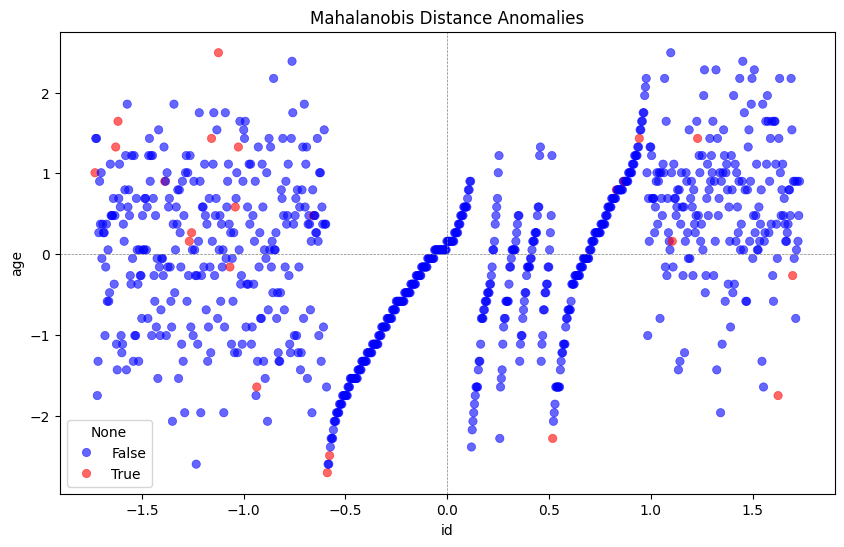

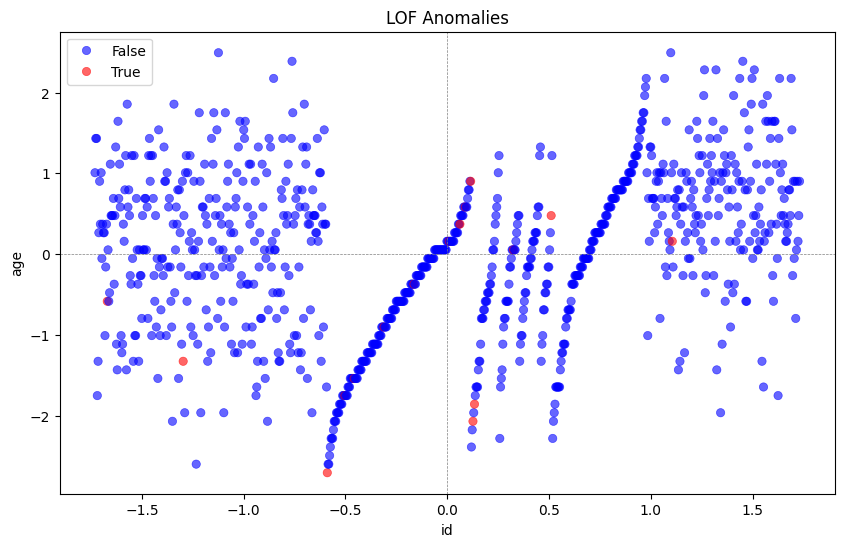

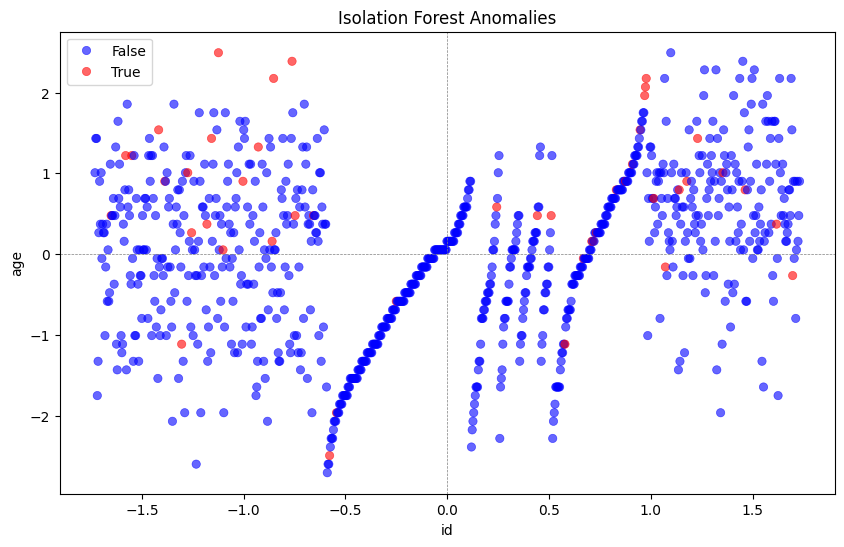

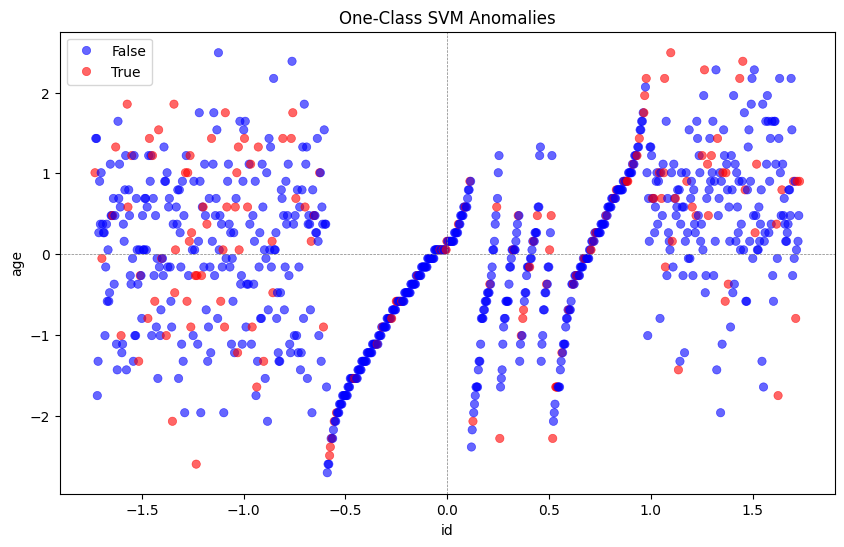

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Function to calculate evaluation metrics
def evaluate_metrics(true_labels, detected_anomalies):
    precision = precision_score(true_labels, detected_anomalies, zero_division=0)
    recall = recall_score(true_labels, detected_anomalies, zero_division=0)
    accuracy = accuracy_score(true_labels, detected_anomalies)
    return precision, recall, accuracy

# Generate synthetic labels for demonstration (1 for anomalies, 0 for normal points)
# In practice, you would replace this with your actual labels if available.
true_labels = np.random.choice([0, 1], size=len(normalized_df), p=[0.95, 0.05])

# Dictionary to store results
results = {
    'Z-score': evaluate_metrics(true_labels, z_anomalies),
    'Mahalanobis': evaluate_metrics(true_labels, m_anomalies),
    'LOF': evaluate_metrics(true_labels, lof_anomalies),
    'Isolation Forest': evaluate_metrics(true_labels, iso_forest_anomalies),
    'One-Class SVM': evaluate_metrics(true_labels, svm_anomalies)
}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results, index=['Precision', 'Recall', 'Accuracy']).T

# Display results
print("Evaluation Metrics for Anomaly Detection Methods:")
print(results_df)

# Visualization of Anomalies
# Function to visualize anomalies
def visualize_anomalies(df, detected_anomalies, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1],
                     hue=detected_anomalies, palette=
                        {True: 'red', False: 'blue'},
                            alpha=0.6, edgecolor=None)
    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.axvline(0, color='grey', lw=0.5, ls='--')
    plt.show()

# Visualize anomalies for each method
visualize_anomalies(normalized_df, z_anomalies, "Z-score Anomalies")
visualize_anomalies(normalized_df, m_anomalies, "Mahalanobis Distance Anomalies")
visualize_anomalies(normalized_df, lof_anomalies, "LOF Anomalies")
visualize_anomalies(normalized_df, iso_forest_anomalies, "Isolation Forest Anomalies")
visualize_anomalies(normalized_df, svm_anomalies, "One-Class SVM Anomalies")
